# Waiting times

In [11]:
import numpy as np
import pandas as pd
import glob, os, re
from num2tex import num2tex
import gsd, gsd.hoomd, itertools

In [12]:
from pylab import *
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
plt.style.use(['science', 'bright'] )
#plt.style.use(['science', 'bright', 'notebook'] )
#plt.style.use('seaborn-paper')
%matplotlib inline
#inline
#%qtconsole
#sns.set_theme('paper')

In [14]:
marker_list = 'osx<>*'
df = dict()

In [15]:
gsd_fname = '/omid/ehsan/active-rods-sims/gsds/dump-v4-2D-Na100-No2500-Ro5-phi0.4-T0-dt1e-2-t_re5e-1-tgsd2e1-Gsigmoid-alpha1e2-phimax0.91-phi00.63-BG0.1-TMrandom-id10.gsd'
gsd_fname = '/omid/ehsan/active-rods-sims/gsds/dump-dump-v4--Na1000-No0500-Ro5-phi0.4-dim2-T0-t_re5e-1-tgsd0.1-Gsigmoid-alpha1e2-phimax0.91-phi00.63-BG0.1-TMrandom-id100.gsd'
gsd_fname = '/omid/ehsan/active-rods-sims/gsds/dump-dump-v4--Na500-No2500-Ro5-phi0.4-dim2-T0-t_re5e-1-tgsd2-Gsigmoid-alpha1e2-phimax0.91-phi00.63-BG0.1-TMrandom-id300.gsd'
gsd_fname = '/omid/ehsan/active-rods-sims/gsds/dump-dump-v4--Na500-No2500-Ro5-phi0.4-dim2-T0-t_re5e-1-tgsd2-Guniform-alpha1e2-phimax0.91-phi00.63-BG0.1-TMrandom-id300.gsd'

In [18]:
traj = gsd.hoomd.open(gsd_fname, 'rb')

In [19]:
s = traj[0]
p_ids = s.particles.typeid==0
L = s.configuration.box[0]

In [20]:
df_rows = dict()
timesteps = []
for s0 in traj[:]:
    timesteps.append(s0.configuration.step)
    pos = s0.particles.position[p_ids]
    img = s0.particles.image[p_ids]
    for i, p0 in enumerate(pos):
        k = 'p%d'%i
        if not(k+'-x' in df_rows.keys()):
            df_rows[k+'-x'] = []
            df_rows[k+'-y'] = []
        df_rows[k+'-x'].append(pos[i, 0] + L*img[i, 0])
        df_rows[k+'-y'].append(pos[i, 1] + L*img[i, 1])
TM = re.findall('(?<=G).*(?=-alpha)', gsd_fname)[0]
df[TM] = pd.DataFrame(df_rows, index=timesteps)

In [37]:
%matplotlib inline
#%qtconsole

NameError: name 'dr_s' is not defined

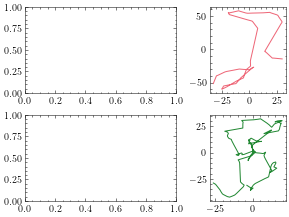

In [38]:
save = False
#save = True
axd = plt.figure(figsize=(4,3), constrained_layout=True).subplot_mosaic(
    '''
    SSA
    UUB
    ''')
#f, axes = figure()
p0_x = 'p5-x'
p0_y = 'p5-y'
dt = 0.01
start = 0/dt
end = 500/dt
xs = dict()
ys = dict()
dr = dict()
steps = dict()
for k in ['sigmoid', 'uniform']:
    xs[k] = df[k].loc[start:end][p0_x]
    ys[k] = df[k].loc[start:end][p0_y]
    dr[k] = (np.diff(xs[k], axis=0)**2 + np.diff(ys[k], axis=0)**2)**0.5
    steps[k] = np.arange(len(dr[k]))*dt
k = 'sigmoid'
axd['A'].plot(xs[k]-xs[k].mean(), ys[k]-ys[k].mean(), '-', color='C1')
k = 'uniform'
axd['B'].plot(xs[k]-xs[k].mean(), ys[k]-ys[k].mean(), '-', color='C2')

axd['S'].plot((np.arange(len(dr_s))*dt)[:150], dr_s[:150], '-', color='C1', label='Sigmoid G')
axd['U'].plot((np.arange(len(dr_u))*dt)[:150], dr_u[:150], '-', color='C2', label='Uniform G')
for k in ['A', 'B']:
    axd[k].set_xticks([])
    axd[k].set_yticks([])
    axd[k].set_xlim(-65, 65)
    axd[k].set_ylim(-65, 65)
    axd[k].set_ylabel('Y')
    axd[k].yaxis.set_label_position('right')
axd['B'].set_xlabel('X')
axd['S'].set_xticklabels([])
for k in ['S', 'U']:
    axd[k].legend(loc='upper right')
    axd[k].set_ylim(0, 3)
    axd[k].set_ylabel('dr')
axd['U'].set_xlabel('t')
if save:
    f = gcf()
    fname = 'plots/dr-traj-phi0_4-t_re5-diffG-2'
    f.savefig(fname+'.pdf', dpi=200, bbox_inches='tight')
    f.savefig(fname+'.svg', dpi=200, bbox_inches='tight')

In [39]:
thr = 5
pool = []
for p0_x, p0_y in zip(df.columns[::2], df.columns[1::2]):
    d = (np.diff(df[p0_x])**2 + np.diff(df[p0_y])**2)**0.5
    trapped_x = np.zeros(len(d)+1)
    trapped_x[1:][d<thr] = 1
    steps = np.arange(len(trapped_x))+1
    d_trapped_x = np.diff(trapped_x)
    start_trapped_t = steps[1:][d_trapped_x==1]
    end_trapped_t = steps[1:][d_trapped_x==-1]
    waiting_times_len = min(len(end_trapped_t), len(start_trapped_t))
    waiting_times = end_trapped_t[:waiting_times_len] - start_trapped_t[:waiting_times_len]
    if (waiting_times<0).any():
        w2 = waiting_times
        break
    pool = pool + waiting_times[waiting_times>-1].tolist()
pool = np.array(pool)   

AttributeError: 'dict' object has no attribute 'columns'

In [437]:
f = figure()
#
plot(steps, trapped_x)
xlim(770, 800)

(770.0, 800.0)

In [427]:
d_trapped_x = np.diff(trapped_x)
plot(steps[1:], d_trapped_x)

In [438]:
start_trapped_t = steps[1:][d_trapped_x==1]
end_trapped_t = steps[1:][d_trapped_x==-1]
waiting_times = end_trapped_t - start_trapped_t[:-1]

In [337]:
plot(steps[2:], np.diff(d_trapped_x))

In [439]:
#escape_times
for s, e in zip(start_trapped_t, waiting_times):
    plot([s,s+e], [0.5, 0.5], '--', color='C5')

In [451]:
pool.shape
pool[:4]

array([ 3,  5, 32, 50])

In [448]:
#bins = np.linspace(pool.min(), pool.max(), 100)
bins = 100
y, b, _ = hist(pool, density=True, bins=bins, align='mid')
yscale('log')
xscale('log')

In [168]:
%qtconsole

In [433]:
start_trapped_t[:-1][waiting_times==1]
end_trapped_t[waiting_times==1]

array([ 784, 1044, 1194, 1814, 5117, 5202, 5204, 5292, 5322, 5327, 5496,
       5546, 5548, 5591, 5595, 5602, 5684, 5722, 5740, 5768, 5885, 6038,
       6152, 6155, 6157, 6295, 6364, 6444, 6471, 6491, 6493, 6527, 6535,
       6537, 6549, 6574, 6580, 6585, 6758, 6770, 6772, 6786, 6788, 6790,
       6792, 6864, 6877, 6897, 6922, 6995, 7042, 7055, 7085, 7096, 7102,
       7104, 7196, 7203, 7205, 7246, 7404, 7406, 7408, 7526, 7601, 7612,
       7646, 7660, 7682, 7707, 7757, 7836, 7881, 8022, 8027, 8145, 8149,
       8214, 8282, 8309, 8342, 8412, 8490, 8493, 8605, 8662, 8734, 8751,
       8796, 8799, 8805, 8819, 8863, 8897, 8979, 9045, 9140, 9195, 9205,
       9238, 9426, 9512, 9525, 9535, 9587, 9619, 9623, 9778, 9825])

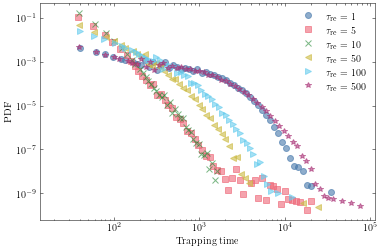

In [260]:
save = True
#save = False
f = figure(figsize=(6,4))
fnt = 'gwdg/trapping-times/trap-v4-dthr10-v4-2D-Na100-No{No}-Ro5-phi{phi}-T0-dt1e-2-t_re5e-1-tgsd2e1-G{G}-alpha1e2-phimax0.91-phi00.63-BG{BG}-TMrandomallsims.txt'
phi = '0.4'
t_re0 = '5e-1'
No = '5000'
G = 'uniform'
df_d = dict()
BG_list = ['0.5', '0.1', '0.05', '0.01', '0.005', '0.001']
m = markers
for BG in BG_list:
    fn = fnt.format(phi=phi, BG=BG, G=G, No=No)
    df_d[BG] = pd.read_csv(fn, comment='#')
    bins = np.logspace(np.log10(df_d[BG].values.min()), np.log10(df_d[BG].values.max()), 70) 
    y, b = np.histogram(df_d[BG], bins=bins, density=True)
    bc = 0.5*(b[:-1]+b[1:])
    plot((bc), y, '%s'%next(m), alpha=0.6, label='$\\tau_{\mathrm{re}} = %s$'%'{:g}'.format(num2tex(float(t_re0)/float(BG))))
xscale('log')
yscale('log')
legend(loc='best')
xlabel('Trapping time')
ylabel('PDF')
if save:
    fn = 'plots/hist-v4-trap-times-phi{phi}-diff-tre-G{G}'.format(G=G, phi=phi)
    fn = fn.replace('.', '_')
    f.savefig(fn+'.pdf', bbox_inches='tight', dpi=200)
    f.savefig(fn+'.svg', bbox_inches='tight', dpi=200)
#grid()

In [262]:
save = True
#save = False
f = figure(figsize=(6,4))
fnt = 'gwdg/trapping-times/trap-v4-dthr10-v5-2D-Na100-No{No}-Ro5-phi{phi}-T0-dt1e-2-t_re5e-1-tgsd2e1-G{G}-alpha1e2-phimax0.91-phi00.63-BG{BG}-TMrandomallsims.txt'
phi = '0.4'
t_re0 = '5e-1'
No = '5000'
G = 'sigmoid'
df_d = dict()
BG_list = ['0.5', '0.1', '0.05', '0.01', '0.005', '0.001'][:]
m = markers
for BG in BG_list:
    fn = fnt.format(phi=phi, BG=BG, G=G, No=No)
    df_d[BG] = pd.read_csv(fn, comment='#')
    bins = np.logspace(np.log10(df_d[BG].values.min()), np.log10(df_d[BG].values.max()), 70) 
    y, b = np.histogram(df_d[BG], bins=bins, density=True)
    bc = 0.5*(b[:-1]+b[1:])
    m0 = next(m)
    plot((bc), y, '%s'%m0,alpha=0.6, label='$\\tau_{\mathrm{re}} = %s$'%'{:g}'.format(num2tex(float(t_re0)/float(BG))))
xscale('log')
yscale('log')
legend(loc='best')
xlabel('Trapping time')
ylabel('PDF')
if save:
    fn = 'plots/hist-v4-trap-times-phi{phi}-diff-tre-G{G}'.format(G=G, phi=phi)
    fn = fn.replace('.', '_')
    f.savefig(fn+'.pdf', bbox_inches='tight', dpi=200)
    f.savefig(fn+'.svg', bbox_inches='tight', dpi=200)
#grid()

In [21]:
%matplotlib inline

In [22]:
BG_list = np.array(['0.5', '0.1', '0.05', '0.01', '0.005', '0.001'])
BG_arrf = BG_list.astype(float)
t_mean2 = np.array([df_d[BG].mean().values for BG in BG_list])


NameError: name 'df_d' is not defined

In [263]:
save = True
#save = False
f = figure(figsize=(4,3))
plot(float(t_re0)/BG_arrf, t_mean, '-o', color='C5', label='G: Sigmoid')
plot(float(t_re0)/BG_arrf, t_mean2, '-s', color='C2', label='G: Uniform')
legend(loc='best')
xscale('log')
yscale('log')
xlabel('$\\tau_{\mathrm{re}}$')
ylabel('Mean trapping time')
#grid()
if save:
    fn = 'plots/mean-trap-times-phi{phi}-diff-tre'.format(phi=phi)
    fn = fn.replace('.', '_')
    f.savefig(fn+'.pdf', bbox_inches='tight', dpi=200)
    f.savefig(fn+'.svg', bbox_inches='tight', dpi=200)


In [153]:
a[0]

TypeError: 'map' object is not subscriptable

In [23]:
df_dict =  {'sigmoid': {}, 'uniform': {}}

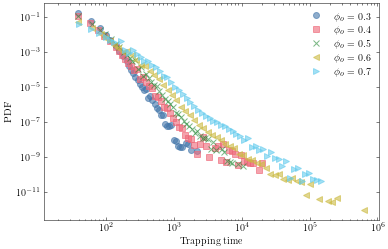

In [24]:
save = True
save = False
f = figure(figsize=(6,4))
fnt = 'gwdg/trapping-times/trap-v4-dthr10-v{v2}-2D-Na100-No{No}-Ro5-phi{phi}-T0-dt1e-2-t_re5e-1-tgsd2e1-G{G}-alpha1e2-phimax0.91-phi00.63-BG{BG}-TMrandomallsims.txt'
phi = '0.4'
t_re0 = '5e-1'
No = '5000'
G = 'uniform'
df_d = dict()
BG_list = ['0.5', '0.1', '0.05', '0.01', '0.005', '0.001']
phi_list = ['0.3', '0.4', '0.5', '0.6', '0.7']
m = itertools.cycle(marker_list)
BG = '0.1'
v2 = '4'
for phi in phi_list:
    if phi=='0.4':
        No = '5000'
    else:
        No = '2500'
    fn = fnt.format(phi=phi, BG=BG, G=G, No=No, v2=v2)
    df_dict[G][phi] = pd.read_csv(fn, comment='#')
    df_d[phi] = df_dict[G][phi]
    #df_d[phi] = pd.read_csv(fn, comment='#')
    bins = np.logspace(np.log10(df_d[phi].values.min()), np.log10(df_d[phi].values.max()), 70) 
    y, b = np.histogram(df_d[phi], bins=bins, density=True)
    bc = 0.5*(b[:-1]+b[1:])
    plot((bc), y, '%s'%next(m), alpha=0.6, label='$\phi_o = %s$'%'{}'.format(phi))
xscale('log')
yscale('log')
legend(loc='best')
xlabel('Trapping time')
ylabel('PDF')
if save:
    fn = 'plots/hist-v4-trap-times-tre5-diff-phi-G{G}'.format(G=G)
    fn = fn.replace('.', '_')
    f.savefig(fn+'.pdf', bbox_inches='tight', dpi=200)
    f.savefig(fn+'.svg', bbox_inches='tight', dpi=200)
#grid()

In [25]:
save = True
save = False
f = figure(figsize=(6,4))
fnt = 'gwdg/trapping-times/trap-v4-dthr10-v{v2}-2D-Na100-No{No}-Ro5-phi{phi}-T0-dt1e-2-t_re5e-1-tgsd2e1-G{G}-alpha1e2-phimax0.91-phi00.63-BG{BG}-TMrandomallsims.txt'
phi = '0.4'
t_re0 = '5e-1'
No = '5000'
G = 'sigmoid'
#G = 'uniform'
df_d = dict()
BG_list = ['0.5', '0.1', '0.05', '0.01', '0.005', '0.001']
phi_list = ['0.3', '0.4', '0.5', '0.6', '0.7']
m = itertools.cycle(marker_list)
BG = '0.1'
v2 = '4'
for phi in phi_list:
    if phi=='0.4':
        No = '5000'
        v2 = '5'
    else:
        No = '2500'
        v2 = '4'
    fn = fnt.format(phi=phi, BG=BG, G=G, No=No, v2=v2)
    df_dict[G][phi] = pd.read_csv(fn, comment='#')
    df_d[phi] = df_dict[G][phi]
    bins = np.logspace(np.log10(df_d[phi].values.min()), np.log10(df_d[phi].values.max()), 70) 
    y, b = np.histogram(df_d[phi], bins=bins, density=True)
    bc = 0.5*(b[:-1]+b[1:])
    plot((bc), y, '%s'%next(m), alpha=0.6, label='$\phi_o = %s$'%'{}'.format(phi))
xscale('log')
yscale('log')
legend(loc='best')
xlabel('Trapping time')
ylabel('PDF')
if save:
    fn = 'plots/hist-v4-trap-times-tre5-diff-phi-G{G}'.format(G=G, phi=phi)
    fn = fn.replace('.', '_')
    f.savefig(fn+'.pdf', bbox_inches='tight', dpi=200)
    f.savefig(fn+'.svg', bbox_inches='tight', dpi=200)
#grid()

In [26]:
Qdrop_u = np.array([[3.000e-01, 1.680e+03],
       [4.000e-01, 2.420e+03],
       [5.000e-01, 3.940e+03],
       [6.000e-01, 2.294e+04],
       [7.000e-01, np.inf]])

Qdrop_s = np.array([[3.000e-01, 1.200e+02],
       [4.000e-01, 3.200e+02],
       [5.000e-01, 9.200e+02],
       [6.000e-01, 1.052e+04],
       [7.000e-01, np.inf]])



In [27]:
phi_arrf = np.array(phi_list).astype(float)
#phi_arrf = phi.astype(float)
t_mean_s = np.array([df_dict['sigmoid'][phi].mean().values for phi in phi_list])
t_mean_u = np.array([df_dict['uniform'][phi].mean().values for phi in phi_list])


In [28]:
save = True
#save = False
f = figure(figsize=(6,3))
subplot(122)
plot(phi_arrf, t_mean_s, '-o', color='C5', label='G: Sigmoid')
plot(phi_arrf, t_mean_u, '-s', color='C2', label='G: Uniform')

ylabel('Mean trapping time')

subplot(121)
plot(phi_arrf, Qdrop_s[:, 1], '-v', color='C5', label='G: Sigmoid')
plot(phi_arrf, Qdrop_u[:, 1], '-^', color='C2', label='G: Uniform')
yscale('log')
ylabel('$\\tau_Q$')
legend(loc='lower right')
#xscale('log')
#yscale('log')
for ax in f.axes:
    ax.set_xlabel('$\phi_o$')

#grid()
tight_layout()
if save:
    fn = 'plots/mean-trap-times-tauQdrop-diff-phi-tre5'.format(phi=phi)
    fn = fn.replace('.', '_')
    f.savefig(fn+'.pdf', bbox_inches='tight', dpi=200)
    f.savefig(fn+'.svg', bbox_inches='tight', dpi=200)


In [600]:
xlabel('Trapping times')
ylabel('Probability density function')
legend()

In [602]:
fname = 'plots/Pdist-trap-times-phi{phi}-Pe{Pe}-dthr{dthr}'.format(phi=phi, Pe=Pe, dthr=dthr)
f = gcf()
f.savefig(fname+'.svg', bbox_inches='tight', dpi=200)
f.savefig(fname+'.pdf', bbox_inches='tight', dpi=200)

In [30]:
t_mean_u

array([[ 42.42053572],
       [ 48.09771531],
       [ 56.81502533],
       [ 74.91306339],
       [117.78257202]])

In [8]:
def g(x, k=1, L=1, x0=0):
    res = L/(1+np.exp(-k*(x-x0)))
    return res
def g_intg(x, k=1, L=1, x0=0):
    res = (L/k)*np.log(1 + np.exp(k*(x-x0)))
    return res

In [15]:
#k = 20
#L = 2
save = True
#save = False
phi_max = 0.9069
x = np.arange(0, phi_max, 0.00001)
phi0 = phi_max*0.5
plot(x, (2*x/(phi_max**2))/(2/phi_max), label='Linear')

for k in [5, 10, 20]:
    L = k* (np.log(1+np.exp(k*(x[-1]-phi0)))-np.log(1+np.exp(k*(x[0]-phi0))))**-1
    y = g(x, x0=phi0, k=k, L=L)
    C = g_intg(x[-1], k=k, L=L, x0=phi0) - g_intg(x[0], k=k, L=L, x0=phi0)
    S = np.sum(y*np.diff(x)[0])
    print(C, S)
    plot(x, (y/C - y[0]/C)/(y[-1]/C - y[0]/C), label='Sigmoid, k={k}'.format(k=k))
axvline(phi0, ls='--', color='black')
axhline(0.5, ls='--', color='black')
xlabel('$\phi_{\mathrm{local}}$')
ylabel('Rescaled $G$')
legend()
if save:
    fname = 'plots/G-lin-logistic-comparison-phi_max{}'.format(phi_max)
    fig = gcf()
    fig.savefig(fname+'.svg', dpi=200, bbox_inches='tight')
    fig.savefig(fname+'.pdf', dpi=200, bbox_inches='tight')

0.9999999999999999 1.0000110267474935
1.0 1.0000110268030526
1.0 1.0000110268169373


In [6]:
from scipy.stats import norm
def sigmoid(x, k, phi0):
    L = k*(np.log(1+np.exp(k*(x[-1]-phi0)))-np.log(1+np.exp(k*(x[0]-phi0))))**-1
    y = g(x, x0=phi0, k=k, L=L)
    C = g_intg(x[-1], k=k, L=L, x0=phi0) - g_intg(x[0], k=k, L=L, x0=phi0)
    return y/C
    

1.000017857780635


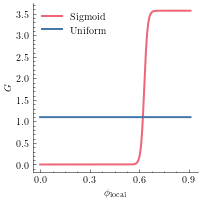

In [36]:
save = False
save = True
f = figure(figsize=(3,3))
#k = 20
#L = 2
lw = 2
alpha = 0.3
phi_max = 0.91
x = np.arange(0, phi_max, 0.00001)
phi0 = 0.63#phi_max*0.5


# sigmoid
k = 100
BG = 1.1
y = sigmoid(x, phi0=phi0, k=k)*BG**0
print(np.sum(y*np.diff(x)[0]))
#print(((y - y[0])/(y[-1] - y[0])).mean())
#plot(x, (y - y[0])/(y[-1] - y[0]), label='Sigmoid,\n k={k}, phi0={phi0}'.format(k=k, phi0=phi0))
plot(x, y, '-', label='Sigmoid', lw=lw, color='C1')
#fill_between(x, y, y2=0, alpha=alpha, color='C1')
# uniform
BG = 1.1
#axhline(BG, )
y = np.ones_like(x)*BG**1
plot(x, y, ls='-', color='C0', label='Uniform', linewidth=lw)
#fill_between(x, y, y2=0, alpha=alpha, color='C0')
ax = gca()
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
xticks([0, 0.3, 0.6, 0.9])
xlabel('$\phi_{\mathrm{local}}$')
ylabel('$\lambda \cdot G$')
ylabel('$G$')
legend()
#grid()
tight_layout()
if save:
    fname = 'plots/4paper/G-uniform-sigmoid-phi_max{}'.format(phi_max)
    fname = fname.replace('.', '_')
    fig = gcf()
    fig.savefig(fname+'.pdf', dpi=200, bbox_inches='tight')
    fname = fname.replace('4paper/', '')
    fig.savefig(fname+'.svg', dpi=200, bbox_inches='tight')

In [11]:
1/phi_max

1.0989010989010988

In [97]:
%matplotlib 

Using matplotlib backend: Qt5Agg


In [48]:
d1 = np.genfromtxt('/omid/ehsan/active-rods-sims/trapping-times/test1.txt')
d1 = np.genfromtxt('gwdg/trapping-times/trap-dthr10-v3-2D-Na100-No500-Ro5-phi0.4-T0-dt1e-2-t_re5e-1-tgsd2e1-Gsigmoid-alpha1e2-phimax0.91-phi00.63-BG0.1-TMrandomallsims.txt')
d3 = np.genfromtxt('/omid/ehsan/active-rods-sims/trapping-times/test2.txt')
d2 = np.genfromtxt('gwdg/trapping-times/trap-dthr10-v3-2D-Na100-No500-Ro5-phi0.4-T0-dt1e-2-t_re5e-1-tgsd2e1-Guniform-alpha1e2-phimax0.91-phi00.63-BG0.1-TMrandomallsims.txt')
d4 = np.genfromtxt('/omid/ehsan/active-rods-sims/trapping-times/test4.txt')
d5 = np.genfromtxt('/omid/ehsan/active-rods-sims/trapping-times/test-phi0.6-t_re5e-2-tgsd1e-2-rt1e2-id1-d5.txt')
d6 = np.genfromtxt('/omid/ehsan/active-rods-sims/trapping-times/test-phi0.6-t_re5e-2-tgsd1e-2-rt1e2-id1-d10.txt')

/tmp/ipykernel_1461356/2456942645.py:6: UserWarning: genfromtxt: Empty input file: "/omid/ehsan/active-rods-sims/trapping-times/test-phi0.6-t_re5e-2-tgsd1e-2-rt1e2-id1-d5.txt"
  d5 = np.genfromtxt('/omid/ehsan/active-rods-sims/trapping-times/test-phi0.6-t_re5e-2-tgsd1e-2-rt1e2-id1-d5.txt')
/tmp/ipykernel_1461356/2456942645.py:7: UserWarning: genfromtxt: Empty input file: "/omid/ehsan/active-rods-sims/trapping-times/test-phi0.6-t_re5e-2-tgsd1e-2-rt1e2-id1-d10.txt"
  d6 = np.genfromtxt('/omid/ehsan/active-rods-sims/trapping-times/test-phi0.6-t_re5e-2-tgsd1e-2-rt1e2-id1-d10.txt')


In [119]:
figure(figsize=(8,6))
bins = 100
bins = np.logspace(1,np.log10(5e4),100)
y1,b1 = np.histogram(d1, bins=bins, density=True)
y2,b2 = np.histogram(d2, bins=bins, density=True)
#y3,b3 = np.histogram(d3*2e-1, bins=bins, density=True)
#y4,b4 = np.histogram(d4*5e-2, bins=bins, density=True)
bc1 = 0.5*(b1[1:]+b1[:-1])
bc2 = 0.5*(b2[1:]+b2[:-1])
#bc3 = 0.5*(b3[1:]+b3[:-1])
#bc4 = 0.5*(b4[1:]+b4[:-1])
plot(bc1, y1, 'x', label='G Sigmoid, $\phi=0.6$, $\\tau_{re}=5$')
#plot(bc4, y4, '-x', label='linear, rt=1e2, sampling time= 5e-2, d=5')
plot(bc2, y2, 'x', label='G uniform, $\phi=0.6$, $\\tau_{re}=5$')
#plot(bc3, y3, '-x', label='linear, rt=1e4, sampling time= 2e-1, d=10')
grid()
yscale('log')
#xlim(0,10)
xscale('log')
xlabel('Trapping times')
ylabel('Hist.')
legend()

In [39]:
%qtconsole

In [118]:
%matplotlib inline

In [37]:
(d1.mean(), d2.mean())

(39.778622640713, 77.99445456378524)

In [414]:
df = pd.read_csv('/omid/ehsan/active-rods-sims/msds-test.tsv', delim_whitespace=True, index_col=0)

In [415]:
df

MSD           0          1          2           3          4  \
time                                                                        
0.00      0.0000      0.0000     0.0000     0.0000      0.0000     0.0000   
0.05     19.2780     22.6182    21.0121    24.5741     24.6436    14.3683   
0.10     56.8602     50.2194    31.1255    96.2023     98.2028    51.5013   
0.15     98.6941     50.6361    30.5965   130.5590    216.7440   142.1340   
0.20    139.5800     50.4496    30.9429   129.6960    383.2960   277.4620   
...          ...         ...        ...        ...         ...        ...   
98.05  7130.9300  12753.9000  5706.8100  3782.8200  32453.3000  3616.0600   
98.10  7166.0000  12779.9000  5075.3800  4056.0000  33532.2000  3549.8000   
98.15  7176.6200  12789.3000  4453.5200  4134.4800  34421.0000  3542.1400   
98.20  7152.5700  12759.6000  4208.6000  4129.0100  34423.7000  3590.4000   
98.25  7196.4700  12785.3000  3882.1200  4103.3100  34457.2000  3973.8800   

               5           6         7          8  ...         90        91  \
time                                               ...                        
0.00      0.0000     0.00000    0.0000     0.0000  ...     0.0000    0.0000   
0.05     24.4774     9.89673   23.1326    16.9705  ...    22.9717   24.6906   
0.10     82.2572    15.18770   75.3864     1.4207  ...    94.8029   66.6727   
0.15    108.9870    15.26570  139.4440    34.2033  ...   177.6500   66.2346   
0.20    217.6680    15.28560  211.9720   117.2000  ...   229.3880   66.6846   
...          ...         ...       ...        ...  ...        ...       ...   
98.05   720.6630  5831.76000   93.5150  5790.0700  ...  4219.0800  205.1820   
98.10   939.9330  5762.41000   92.6500  6571.3000  ...  4871.0600  206.0100   
98.15  1016.2800  5584.02000   56.3047  7380.8400  ...  5098.9000  111.8220   
98.20  1015.7900  5437.23000  100.5780  8237.7900  ...  5657.4200   36.2504   
98.25  1014.1100  5477.69000  114.3510  9158.5100  ...  6191.1500   22.5164   

             92         93            94         95         96         97  \
time                                                                        
0.00    0.00000     0.0000      0.000000     0.0000     0.0000     0.0000   
0.05   24.74690    24.4278     21.444200    24.5739    23.7157    16.5781   
0.10   41.07960    96.8963      0.826809    98.1223    92.5659    22.4184   
0.15    3.07066   213.7910     20.244600   183.8760   157.4440    22.4890   
0.20    6.71998   364.4910     80.278000   302.6520    53.9061    17.9840   
...         ...        ...           ...        ...        ...        ...   
98.05  45.40370  7232.7700  29522.300000  7296.1100   772.6760  6414.1300   
98.10  47.43220  7221.5900  28782.700000  8113.9900   532.6290  6443.0000   
98.15  43.75370  7275.1700  27294.100000  8962.1800   739.1260  6433.5200   
98.20  41.56740  7286.7900  25697.800000  9610.4800   979.7120  6288.9500   
98.25  42.18510  7283.7400  24301.900000  9600.7700  1246.4600  6802.4300   

               98         99  
time                          
0.00       0.0000     0.0000  
0.05      24.7475    24.1767  
0.10      33.7334    77.9124  
0.15      34.4439   154.9600  
0.20      33.7810   248.0930  
...           ...        ...  
98.05  14161.3000  7465.8300  
98.10  14171.7000  7673.3300  
98.15  14153.5000  7929.9000  
98.20  14171.1000  7715.7800  
98.25  14103.2000  7393.1600  

[1966 rows x 101 columns]

In [423]:
plot(df.index, df['0'])

In [417]:
%matplotlib

Using matplotlib backend: Qt5Agg


In [419]:
y = df['0']

In [424]:
plot(y)

In [425]:
df2 = pd.DataFrame(index=df.index)

In [433]:
df2['trapped'] = 0
idx0 = df2.index[0]

In [434]:
y = y**0.5

In [452]:
plot(y.diff())

In [451]:
plot(y)

In [443]:
fig = figure()

In [446]:
hist(y.diff().values, bins=50)

(array([  6.,   5.,  35.,  36.,  35.,  30.,  32.,  28.,  28.,  25.,  28.,
         22.,  24.,  17.,  18.,  21.,  22.,  20.,  19.,  20.,  24.,  28.,
         32.,  66., 587., 150.,  35.,  28.,  19.,  22.,  24.,  26.,  12.,
         30.,  23.,  28.,  31.,  30.,  28.,  30.,  37.,  31.,  25.,  39.,
         31.,  31.,  34.,   7.,   3.,   3.]),
 array([-5.50205466, -5.27843901, -5.05482336, -4.8312077 , -4.60759205,
        -4.3839764 , -4.16036074, -3.93674509, -3.71312944, -3.48951378,
        -3.26589813, -3.04228248, -2.81866682, -2.59505117, -2.37143552,
        -2.14781986, -1.92420421, -1.70058856, -1.4769729 , -1.25335725,
        -1.0297416 , -0.80612594, -0.58251029, -0.35889464, -0.13527898,
         0.08833667,  0.31195232,  0.53556797,  0.75918363,  0.98279928,
         1.20641493,  1.43003059,  1.65364624,  1.87726189,  2.10087755,
         2.3244932 ,  2.54810885,  2.77172451,  2.99534016,  3.21895581,
         3.44257147,  3.66618712,  3.88980277,  4.11341843,  4.33703408,
 